<center> 
    <h1> COVID-19 Tweet Sentiment Analysis </h1>
    <h2> LP2 Data Mining and Warehousing Mini Project </h2> 
    <h3>By<br>
        41233 Rutuja Kawade<br>
        41230 Rohith Kandlagunta<br>
        41232 Fatema Katawala<br>
    </h3>
</center>

In [1]:
import pandas as pd
import numpy as np
import re 
import nltk 

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

### Importing Dataset

In [3]:
train_data = pd.read_csv('Corona_NLP_train.csv',encoding='latin1')
train_data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
test_file = pd.read_csv('Corona_NLP_test.csv',encoding='latin1')
test_file

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [5]:
print('Training Set Shape = {}'.format(train_data.shape))
print('Test Set Shape = {}'.format(test_file.shape))

Training Set Shape = (41157, 6)
Test Set Shape = (3798, 6)


### Data Preprocessing: Removing Null Values

In [6]:
train_data.isnull().sum().sort_values(ascending=False)

Location         8590
UserName            0
ScreenName          0
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
train_data.drop(columns=['Location'], axis=1)

,UserName,ScreenName,TweetAt,OriginalTweet,Sentiment
0,3799,48751,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...
41152,44951,89903,14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [8]:
train_data['text'] = train_data.OriginalTweet
train_data["text"] = train_data["text"].astype(str)

test_file['text'] = test_file.OriginalTweet
test_file["text"] = test_file["text"].astype(str)

### Converting Categorical Labels to Numeric Labels

In [9]:
def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

train_data['label']=train_data['Sentiment'].apply(lambda x:classes_def(x))
test_file['label']=test_file['Sentiment'].apply(lambda x:classes_def(x))


train_data.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

### Removing URLs and HTML from Tweets

In [10]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
train_data['text_new']=train_data['text'].apply(lambda x:remove_urls(x))
test_file['text_new']=test_file['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
train_data['text']=train_data['text_new'].apply(lambda x:remove_html(x))
test_file['text']=test_file['text_new'].apply(lambda x:remove_html(x))

### Converting the Tweet text to lowercase

In [11]:
def lower(text):
    low_text= text.lower()
    return low_text
train_data['text_new']=train_data['text'].apply(lambda x:lower(x))
test_file['text_new']=test_file['text'].apply(lambda x:lower(x))

### Removing numerical values from Tweet text

In [12]:
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
train_data['text']=train_data['text_new'].apply(lambda x:remove_num(x))
test_file['text']=test_file['text_new'].apply(lambda x:remove_num(x))

### Removing Punctuation and Stopwords

In [13]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
train_data['text_new']=train_data['text'].apply(lambda x:punct_remove(x))
test_file['text_new']=test_file['text'].apply(lambda x:punct_remove(x))

In [14]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
train_data['text']=train_data['text_new'].apply(lambda x:remove_stopwords(x))
test_file['text']=test_file['text_new'].apply(lambda x:remove_stopwords(x))

### Removing @ Mentions, # Hashtags, and Spaces

In [15]:
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
train_data['text_new']=train_data['text'].apply(lambda x:remove_mention(x))
test_file['text_new']=test_file['text'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
train_data['text']=train_data['text_new'].apply(lambda x:remove_hash(x))
test_file['text']=test_file['text_new'].apply(lambda x:remove_hash(x))

def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
train_data['text_new']=train_data['text'].apply(lambda x:remove_space(x))
test_file['text_new']=test_file['text'].apply(lambda x:remove_space(x))
test_file = test_file.drop(columns=['text_new'])
train_data = train_data.drop(columns=['text_new'])

### Preprocessed Data

In [16]:
train_data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil_gahan chrisitv,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak im paranoi...,0
...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airline pilots offering stock supermarket shel...,1
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,response complaint provided citing covid relat...,0
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,know itâs getting tough kameronwilds rationing...,2
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer starting turn coron...,1


### TF-IDF

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english')

train_tfidf = tfidf.fit_transform(train_data.text)
test_tfidf = tfidf.transform(test_file.text)

## Classifier #1: Multinomial Naive Bayes

In [18]:
nb = MultinomialNB()
nb.fit(train_tfidf, train_data.label)
nb_model = nb.predict(test_tfidf)

accuracy_score(test_file.label, nb_model)

0.6708794102159031

<AxesSubplot:>

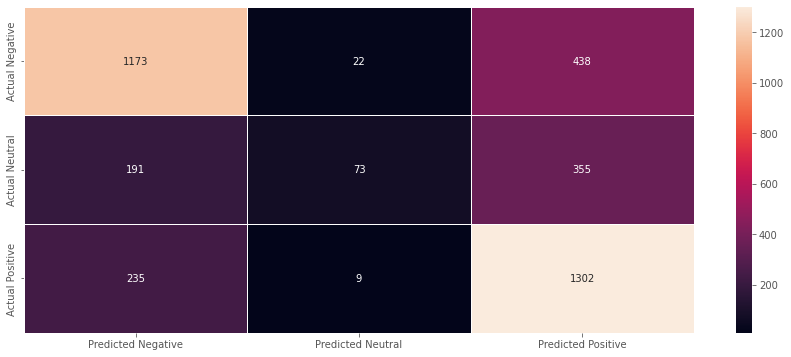

In [19]:
nb_conf = confusion_matrix(test_file.label, nb_model)
ylabel = ["Actual Negative","Actual Neutral", "Actual Positive"]
xlabel = ["Predicted Negative","Predicted Neutral", "Predicted Positive"]
plt.figure(figsize=(15,6))
sns.heatmap(nb_conf, annot=True, xticklabels = xlabel, yticklabels = ylabel, linecolor='white', linewidths=1, fmt='g')


## Classifier #2: Linear Support Vector

In [20]:
lsvc = LinearSVC()
lsvc.fit(train_tfidf, train_data.label)
lsvc_model = lsvc.predict(test_tfidf)

accuracy_score(test_file.label, lsvc_model)

0.7838335966298051

<AxesSubplot:>

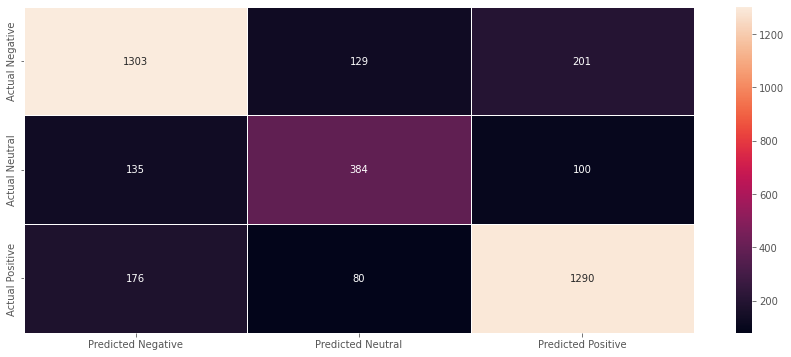

In [21]:
lsv_conf = confusion_matrix(test_file.label, lsvc_model)
ylabel = ["Actual Negative","Actual Neutral", "Actual Positive"]
xlabel = ["Predicted Negative","Predicted Neutral", "Predicted Positive"]
plt.figure(figsize=(15,6))
sns.heatmap(lsv_conf, annot=True, xticklabels = xlabel, yticklabels = ylabel, linecolor='white', linewidths=1, fmt='g')

## Classifier #3: Random Forest

In [22]:
rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(train_tfidf, train_data.label)
rfc_model = rfc.predict(test_tfidf)

accuracy_score(test_file.label, rfc_model)

0.7043180621379673

<AxesSubplot:>

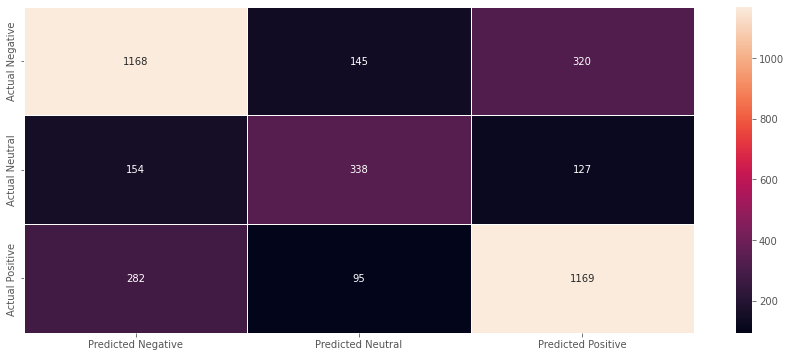

In [23]:
rf_conf = confusion_matrix(test_file.label, rfc_model)
ylabel = ["Actual Negative","Actual Neutral", "Actual Positive"]
xlabel = ["Predicted Negative","Predicted Neutral", "Predicted Positive"]
plt.figure(figsize=(15,6))
sns.heatmap(rf_conf, annot=True, xticklabels = xlabel, yticklabels = ylabel, linecolor='white', linewidths=1, fmt='g')

## Comparing the 3 Models

In [24]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

scoringDict = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score, average='weighted'),
           'recall':make_scorer(recall_score, average='weighted'), 
           'f1_score':make_scorer(f1_score, average='weighted')}

In [25]:
df = pd.concat([train_data, test_file])
df_tfidf = tfidf.transform(df.text)

def models_evaluation(X, y, folds):
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    # Perform cross-validation to each machine learning classifier
    LSVC = cross_validate(lsvc, X, y, cv=folds, scoring=scoringDict)
    RFC = cross_validate(rfc, X, y, cv=folds, scoring=scoringDict)
    MNB = cross_validate(nb, X, y, cv=folds, scoring=scoringDict)

    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Linear Support Vector':[LSVC['test_accuracy'].mean(),
                                                                   LSVC['test_precision'].mean(),
                                                                   LSVC['test_recall'].mean(),
                                                                   LSVC['test_f1_score'].mean()],
                                       
                                      'Random Forest':[RFC['test_accuracy'].mean(),
                                                       RFC['test_precision'].mean(),
                                                       RFC['test_recall'].mean(),
                                                       RFC['test_f1_score'].mean()],
                                       
                                      'Multinomial Naive Bayes':[MNB['test_accuracy'].mean(),
                                                              MNB['test_precision'].mean(),
                                                              MNB['test_recall'].mean(),
                                                              MNB['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)
  
# Run models_evaluation function
cross_table = models_evaluation(df_tfidf, df.label, 5)

In [26]:
cross_nb = cross_table['Multinomial Naive Bayes']['Accuracy'] * 100
cross_lsv = cross_table['Linear Support Vector']['Accuracy'] * 100
cross_rf = cross_table['Random Forest']['Accuracy'] * 100

In [27]:
from tkinter import *
from tkinter import filedialog

In [28]:
def switchHelper(argument): 
    print(argument)
    switcher = {
        "0": "Negative", 
        "1": "Neutral", 
        "2": "Positive", 
    }
    return switcher.get(argument, "Neutral")

In [29]:
def predictSentence(text):
    text = lower(text)
    text = remove_num(text)
    text = punct_remove(text)
    text = remove_stopwords(text)
    text = remove_mention(text)
    text = remove_hash(text)
    text = remove_space(text)
    
    tfidfVector = tfidf.transform([text])
    
    nb_pred_label = nb.predict(tfidfVector)
    return nb_pred_label

In [30]:
def predictSentenceHelper():
    pred = predictSentence(tweetInput.get())
    pred_class = switchHelper(pred[0])

    labelPredict = Label(root, text=pred_class)
    labelPredict.grid(row=6, column=1)

In [31]:
# f = 'Corona_NLP_test.csv'
def predictFile(f):
    test_data = pd.read_csv(f,encoding='latin1')
    
    #Preprocess test file
    test_data['text'] = test_data.OriginalTweet
    test_data["text"] = test_data["text"].astype(str)
    test_data['label']=test_data['Sentiment'].apply(lambda x:classes_def(x))
    test_data['text_new']=test_data['text'].apply(lambda x:remove_urls(x))
    test_data['text']=test_data['text_new'].apply(lambda x:remove_html(x))
    test_data['text_new']=test_data['text'].apply(lambda x:lower(x))
    test_data['text']=test_data['text_new'].apply(lambda x:remove_num(x))
    test_data['text_new']=test_data['text'].apply(lambda x:remove_mention(x))
    test_data['text']=test_data['text_new'].apply(lambda x:remove_hash(x))
    test_data['text_new']=test_data['text'].apply(lambda x:remove_space(x))
    test_data = test_data.drop(columns=['text_new'])
    
    tfidf_file = tfidf.transform(test_data.text)
    nb_model = nb.predict(tfidf_file)
    model_acc = [accuracy_score(test_data.label, nb_model)*100]
    
    lsvc_model = lsvc.predict(tfidf_file)
    model_acc.append(accuracy_score(test_data.label, lsvc_model)*100)
    
    rfc_model = rfc.predict(tfidf_file)
    model_acc.append(accuracy_score(test_data.label, rfc_model)*100)
    
    return model_acc
    
# predictFile(f)

In [32]:
def predictFileHelper():
    filename = filedialog.askopenfilename(initialdir="/env/LP2/DMW_Mini/", title="Select File")
    model_acc = predictFile(filename)
    
    show_confusion(model_acc)

In [33]:
def clear_frame():
    for w in root.winfo_children():
        w.destroy()

In [34]:
def show_confusion(model_acc):
    clear_frame()
    
    labelTitle = Label(root, text='COVID-19 Tweet Sentiment Analysis', font='Helvetica 20 bold')
    labelTitle.grid(row=2, columnspan=5)
    
    Label(root, text='Naive Bayes').grid(row=3,column=1)
    Label(root, text=f'Accuracy: {str(round(model_acc[0],2))}%').grid(row=4,column=1 )
    Label(root, text=f'Confusion Matrix: ').grid(row=5,column=1 )
    Label(root, text=f'{nb_conf}').grid(row=6,column=1 )
    Label(root, text=f'Accuracy after Cross Validation: {str(round(cross_nb,2))}%').grid(row=7,column=1 )

    Label(root, text='').grid(column=2)
    
    Label(root, text='Linear Support Vector').grid(row=3,column=3)
    Label(root, text=f'Accuracy: {str(round(model_acc[1],2))}%').grid(row=4,column=3 )
    Label(root, text=f'Confusion Matrix: ').grid(row=5,column=3 )
    Label(root, text=f'{lsv_conf}').grid(row=6,column=3 )
    Label(root, text=f'Accuracy after Cross Validation: {str(round(cross_lsv,2))}%').grid(row=7,column=3 )
    
    Label(root, text='').grid(column=2)
    
    Label(root, text='Random Forest').grid(row=3,column=5)
    Label(root, text=f'Accuracy: {str(round(model_acc[2],2))}%').grid(row=4,column=5 )
    Label(root, text=f'Confusion Matrix: ').grid(row=5,column=5 )
    Label(root, text=f'{rf_conf}').grid(row=6,column=5 )
    Label(root, text=f'Accuracy after Cross Validation: {str(round(cross_rf,2))}%').grid(row=7,column=5 )


In [35]:
root = Tk()

#Custom Input

labelTitle = Label(root, text='COVID-19 Tweet Sentiment Analysis', font='Helvetica 20 bold')
labelTitle.grid(row=1, column=0,columnspan=5, rowspan=1)

tweetInput = Entry(root, width=15)
tweetInput.insert(0, 'Enter Tweet')

tweetInput.grid(row=4,column=0)

predictButton = Button(root, text="Predict", command=predictSentenceHelper)
predictButton.grid(row=7,column=1)

labelOR = Label(root, text="OR")
labelOR.grid(row=4, column=1)

# File Input
button_file_open = Button(root, text="Browse File", command=predictFileHelper)
button_file_open.grid(row=4,column=2)

root.mainloop()

2
